In [23]:
# Packages
import numpy as np
import sklearn 
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy.integrate import odeint

from utility_code.utility import utils

In [24]:
#import csvs
train = pd.read_csv("ucla2020-cs145-covid19-prediction/train.csv")
test = pd.read_csv("ucla2020-cs145-covid19-prediction/test.csv")
graph = pd.read_csv("ucla2020-cs145-covid19-prediction/graph.csv")

## BASIC S-I-R-D Model

In [25]:
# Total population, N.
N = 1000
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0, D0 = 1, 0, 0
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0 - D0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
# delta is death rate
beta, gamma = 0.4, 1./10 
delta = 0.2
# A grid of time points (in days)
t = np.linspace(0, 160, 160)

In [26]:
def deriv(y, t, N, beta, gamma, delta):
    S, I, R, D = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - (gamma+delta) * I 
    dRdt = gamma * I
    dDdt = delta * I
    return dSdt, dIdt, dRdt, dDdt

In [27]:
# Initial conditions vector
y0 = S0, I0, R0, D0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta))
S, I, R, D = ret.T

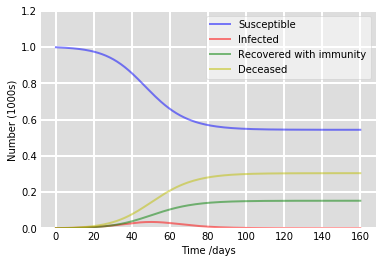

In [28]:
# Plot the data on three separate curves for S(t), I(t) and R(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(t, S/1000, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(t, I/1000, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(t, R/1000, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.plot(t, D/1000, 'y', alpha=0.5, lw=2, label='Deceased')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

## Now to see if we can handle changing values for params

In [29]:
betas = [0.2, 0.3, 0.4, 0.2, 0.1]
gammas = [0.1, 0.1, 0.1, 0.1, 0.1]
deltas = [0.2, 0.1, 0.1, 0.1, 0.15]

# Initial conditions vector
# Total population, N.
N = 1000
# Initial number of infected and recovered individuals, I0 and R0.
I0, R0, D0 = 100, 0, 0
# Everyone else, S0, is susceptible to infection initially
S0 = N - I0 - R0 - D0
window = 5
t = np.linspace(0, window, window)
y0 = S0, I0, R0, D0
print('y0', y0)

S_pred = [S0]
I_pred = [I0]
R_pred = [R0]
D_pred = [D0]

for i in range(len(betas)):
    beta = betas[i]
    gamma = gammas[i]
    delta = deltas[i]
    print('beta, gamma, delta', beta, gamma, delta)
    
    # Integrate the SIR equations over the time grid, t.
    ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta))
    S, I, R, D = ret.T
    y0 = S[len(S)-1], I[len(I)-1], R[len(R)-1], D[len(D)-1]
    S_pred.extend(S[1:len(S)-1].tolist())
    I_pred.extend(I[1:len(I)-1].tolist())
    R_pred.extend(R[1:len(R)-1].tolist())
    D_pred.extend(D[1:len(D)-1].tolist())
    

y0 (900, 100, 0, 0)
beta, gamma, delta 0.2 0.1 0.2
beta, gamma, delta 0.3 0.1 0.1
beta, gamma, delta 0.4 0.1 0.1
beta, gamma, delta 0.2 0.1 0.1
beta, gamma, delta 0.1 0.1 0.15


In [30]:
times = [0]
for i in range(len(betas)):
    times.extend((t[1:len(t)-1] + i*window).tolist())
times

[0,
 1.25,
 2.5,
 3.75,
 6.25,
 7.5,
 8.75,
 11.25,
 12.5,
 13.75,
 16.25,
 17.5,
 18.75,
 21.25,
 22.5,
 23.75]

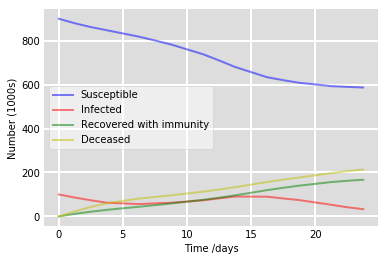

In [31]:
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(times, S_pred, 'b', alpha=0.5, lw=2, label='Susceptible')
ax.plot(times, I_pred, 'r', alpha=0.5, lw=2, label='Infected')
ax.plot(times, R_pred, 'g', alpha=0.5, lw=2, label='Recovered with immunity')
ax.plot(times, D_pred, 'y', alpha=0.5, lw=2, label='Deceased')
ax.set_xlabel('Time /days')
ax.set_ylabel('Number (1000s)')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

## What can we get from the data we have

In [32]:
# Let's check the last 5 days
window = 5
num_states = 50
validation = train.tail(window*num_states)
validation_ala = validation.iloc[::num_states,:]
forparams = train.tail(window*2*num_states).head(window*num_states)
forparams_ala = forparams.iloc[::num_states,:]

In [33]:
beta = forparams_ala['Active'].mean()/4.9e6
gamma = forparams_ala['Recovered'].divide(forparams_ala['Confirmed']).mean()/100
delta = forparams_ala['Mortality_Rate'].mean()/10000

# Initial number of infected and recovered individuals, I0 and R0.
I0, R0, D0 = forparams_ala.iloc[window-1,6], forparams_ala.iloc[window-1, 5], forparams_ala.iloc[window-1,4]
# Total population, N.
N = 4.9e6 # from internet
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0 - D0
# Contact rate, beta, and mean recovery rate, gamma, (in 1/days).
# delta is death rate

# A grid of time points (in days)
t = np.linspace(0, window, window)

# Initial conditions vector
y0 = S0, I0, R0, D0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta))
S, I, R, D = ret.T

In [34]:
gamma

0.003890449763988141

In [35]:
forparams_ala['Hospitalization_Rate']

6600    11.788845
6650    11.734747
6700    11.818182
6750    11.764555
6800    11.743841
Name: Hospitalization_Rate, dtype: float64

In [36]:
validation_ala

,ID,Province_State,Date,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate
6850,6850,Alabama,08-27-2020,121023,2076,48028.0,70919.0,2468.252779,956809.0,14005.0,1.715376,19514.030166,11.57218
6900,6900,Alabama,08-28-2020,122185,2107,48028.0,72050.0,2491.951660,964863.0,NaN,1.724434,19678.290744,NaN
6950,6950,Alabama,08-29-2020,123889,2152,48028.0,73709.0,2526.704581,975818.0,NaN,1.737039,19901.716945,NaN
7000,7000,Alabama,08-30-2020,125235,2162,48028.0,75045.0,2554.156125,981062.0,NaN,1.726354,20008.667835,NaN
7050,7050,Alabama,08-31-2020,126058,2182,48028.0,75848.0,2570.941133,985287.0,NaN,1.730949,20094.836316,NaN


In [46]:
y = [sum(x) for x in zip(I.tolist(), R.tolist())]
y = [sum(x) for x in zip(y, D.tolist())]
y

[119254.0,
 120452.31292788632,
 121664.94457560887,
 122892.06379716449,
 124133.83184371446]

In [ ]:
D.tolist()